# Likelihood Analysis of the Crab with fermipy

Instructions on installing fermipy and the Fermi ScienceTools : [fermipy Installation Instructions](http://fermipy.readthedocs.org/en/latest/install.html). 

Documentation for fermipy : [fermipy](http://fermipy.readthedocs.org)

Credit : notebook adapted from [Likelihood Analysis of a bright point source with fermipy](https://nbviewer.org/github/me-manu/fermipy-extra/blob/master/notebooks/pg1553.ipynb)

## Get the Data

The data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections :

### Make a file list

First you need to make a file containing the list of all your input event files.

Read one file as a table

## Make a config file


Make a config file named 'config.yaml' ([yaml](http://yaml.org) format). For more details on the config file see [config.html](http://fermipy.readthedocs.org/en/latest/config.html). 

In [1]:
cat config_0.1GeV/config_J1932_15_bin_6

data:
  evfile : data_0.1GeV/photon_files.txt # list of photon files
  scfile : data_0.1GeV/L2206060606222DE20A3589_SC00.fits # spacecraft file

binning:
  roiwidth   : 15.0
  binsz      : 0.06
  binsperdec : 6

selection :
  emin : 100 # minimum energy
  emax : 1000000 # maximum energy
  zmax    : 90 # zenith angle cut
  evclass : 128 # event class : simple point source analysis for pass 8
  evtype  : 3 # event type (front 1 + back events 2 = 3)
  tmin : 239557417  # starting time
  tmax : 673405656  # ending time
  filter : DATA_QUAL>0 && LAT_CONFIG==1 # Recommendation for Galactic Point Source Analysis 
  ra : 292.747
  dec : 18.944

gtlike:
  edisp : -2 # Enable energy dispersion
  irfs : 'P8R3_SOURCE_V3'
  edisp_disable : ['isodiff'] # Never enable energy dispersion for the isodiff or galdiff models

model:
  src_roiwidth : 25.0 # Includes sources outside of the ROI
  galdiff  : 'gll_iem_v07.fits' # The most recent and up to date model of the galactic diffuse emission
  isodiff  :

## Start the analysis

Next, you create an analysis script and run the setup steps (which include running the selections and generating exposure maps for example). This will take some time to run.

Fermipy will load the point source model, create an xml file for you which contains the models for all your sources in the region of interest (ROI).  All of this is configurable from python or from the config file. 

### Load up some useful modules

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS

Let's ignore some deprecation warnings

In [3]:
import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning) 

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  
The verbosity parameter is set to 3 (INFO) which supresses DEBUG output. 

In [4]:
from fermipy.gtanalysis import GTAnalysis
gta = GTAnalysis('config_0.1GeV/config_J1932_15_bin_6',logging={'verbosity': 3},fileio={'outdir': 'J1932+1916_0.1GeV_15_bin6'})
matplotlib.interactive(True)

2022-06-10 11:00:03 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.0.1 
ScienceTools version 2.0.8


### The setup routine

This gets everything ready for the likelihood analysis.  Note that fermipy will skip generating any files that already exist in the working directory.

In [5]:
gta.setup()

2022-06-10 11:00:04 INFO    GTAnalysis.setup(): Running setup.
2022-06-10 11:00:04 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2022-06-10 11:00:04 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2022-06-10 11:00:04 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/fermipy/irfs.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  log_ratio = np.log(x[xs1] / x[xs0])
/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/fermipy/irfs.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, w

Drm_Cache::update Measured counts < 0 4FGL J1842.1+2737 23 -1.18245e-15 7.31909e-16
0.239203 0.456312 0.6406 0.649341 0.501611 0.326119 0.167895 0.0684979 0.0260394 0.0078816 0.0019261 0.000515416 0.000135349 3.22454e-05 6.72369e-06 1.18531e-06 1.61899e-07 1.63127e-08 1.28396e-09 7.82217e-11 4.50208e-12 2.30038e-13 1.18336e-14 7.31909e-16 


2022-06-10 11:00:21 INFO    GTAnalysis.setup(): Initializing source properties
2022-06-10 11:00:27 INFO    GTAnalysis.setup(): Finished setup.


In [6]:
h = fits.open('J1932+1916_15_bin_3/ccube_00.fits')
filtered = fits.open('J1932+1916_15_bin_3/ft1_00.fits')
t_filtered = Table(filtered[1].data)
catalog = fits.open('gll_psc_v22.fit')

Let's have a look at the components of the model :

In [7]:
 gta.print_model()

2022-06-10 11:00:29 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
4FGL J1932.3+1916      0.449   2.791  3.99e-05   3.72       nan     30071.8     
4FGL J1929.8+1832      0.482   1.614  1.03e-05   2.42       nan      8548.1     
4FGL J1934.3+1859      0.794   2.658  1.32e-05   4.26       nan     12505.2     
4FGL J1928.4+1801c     1.104   0.954  1.01e-05   2.46       nan      8660.5     
4FGL J1936.6+1921      1.399   0.324  2.48e-06   2.74       nan       975.9     
4FGL J1929.0+1729      1.527   1.526  1.43e-05   3.17       nan     10051.3     
4FGL J1935.2+2029      1.846   1.062  2.33e-05   3.82       nan     22687.6     
4FGL J1925.2+1729      1.991   2.976  6.32e-06   4.69       nan      3730.9     
4FGL J1931.1+1656      2.000   2.820  1.69e-05   3.15       nan     12572.4     
4FGL J1925.1+1707      2.289   0.510  8.78e-06   2.47 

Before proceeding with the analysis let's have a quick look at the files that are produced by the setup function.

In [8]:
ls J1932+1916_15_bin_3/*fits

J1932+1916_15_bin_3/4fgl_j1925.2+1729_sed.fits
J1932+1916_15_bin_3/4fgl_j1928.4+1801c_sed.fits
J1932+1916_15_bin_3/4fgl_j1929.0+1729_sed.fits
J1932+1916_15_bin_3/4fgl_j1932.3+1916i_ext.fits
J1932+1916_15_bin_3/4fgl_j1932.3+1916i_sed.fits
J1932+1916_15_bin_3/4fgl_j1932.3+1916_sed.fits
J1932+1916_15_bin_3/4fgl_j1935.2+2029_sed.fits
J1932+1916_15_bin_3/bexpmap_00.fits
J1932+1916_15_bin_3/bexpmap_roi_00.fits
J1932+1916_15_bin_3/ccube_00.fits
J1932+1916_15_bin_3/ccube.fits
J1932+1916_15_bin_3/ft1_00.fits
J1932+1916_15_bin_3/ltcube_00.fits
J1932+1916_15_bin_3/mcube_Pulsar_J1932_00.fits
J1932+1916_15_bin_3/mcube_Pulsar_J1932.fits
J1932+1916_15_bin_3/mcube_Reference_00.fits
J1932+1916_15_bin_3/mcube_Reference.fits
J1932+1916_15_bin_3/Pulsar_J1932.fits
J1932+1916_15_bin_3/Reference.fits
J1932+1916_15_bin_3/Reference_pointsource_powerlaw_2.00_residmap.fits
J1932+1916_15_bin_3/srcmap_00.fits


Here is a brief explanation of the contents of each file and its role in the analysis:

* **ft1_00.fits**: Event list.  This is generated by running gtselect and gtmktime on our input file list.
* **bexpmap_00.fits**: All-sky binned exposure map.  This map is interpolated to create an exposure model when generating the srcmap file.
* **bexpmap_roi_00.fits**: Binned exposure map for the ROI.  This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
* **ccube_00.fits**: Counts cube for the ROI.
* **ltcube_00.fits**: Livetime cube.  This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
* **srcmap_00.fits**: Source map cube.  This file contains maps for each of the components in the ROI after convolution with exposure and the PSF.  Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'.  This is the analysis component index.  In a multi-component analysis there would be instances of all of the above files for each analysis component.  The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file.  This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates.  In the example below we sum over the energy dimension of the cube to make a 2-D sky image.

Filename: J1932+1916_15_bin_3/ccube_00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     138   (750, 750, 9)   int32   
  1  EBOUNDS       1 BinTableHDU     43   9R x 3C   [I, 1E, 1E]   
  2  GTI           1 BinTableHDU     50   76600R x 2C   [D, D]   


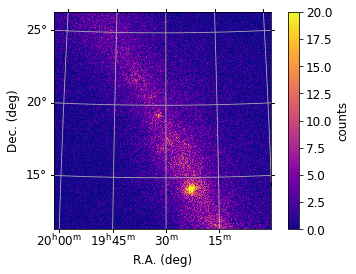

In [9]:


#h = fits.open('J1928+178_15_bin3/ccube_00.fits')
h.info()

wcs = WCS(h[0].header).dropaxis(-1)  # load the coordinate system, drop the energy axis

counts = h[0].data

plt.subplot(projection=wcs)
im = plt.imshow(np.sum(counts,axis=0),vmax= 20,interpolation='nearest',origin='lower', cmap='plasma')

plt.grid()
plt.gca().tick_params(direction='out')
plt.gca().set_xlabel("R.A. (deg)")
plt.gca().set_ylabel("Dec. (deg)")
plt.colorbar(im, label="counts")
plt.show()
#plt.savefig("Crab_5_bin_6/ccube_00.png")

In [10]:
#filtered = fits.open('J1928+178_15_bin3/ft1_00.fits')
#t_filtered = Table(filtered[1].data)

In [11]:
x=t_filtered['RA']
y=t_filtered['DEC']
z=t_filtered['ENERGY']

In [12]:
print('x_min',np.min(x))
print('x_max',np.max(x))

x_min 280.9983
x_max 304.49734


Text(0.5, 1.0, 'Count maps of 13 years of Fermi LAT data')

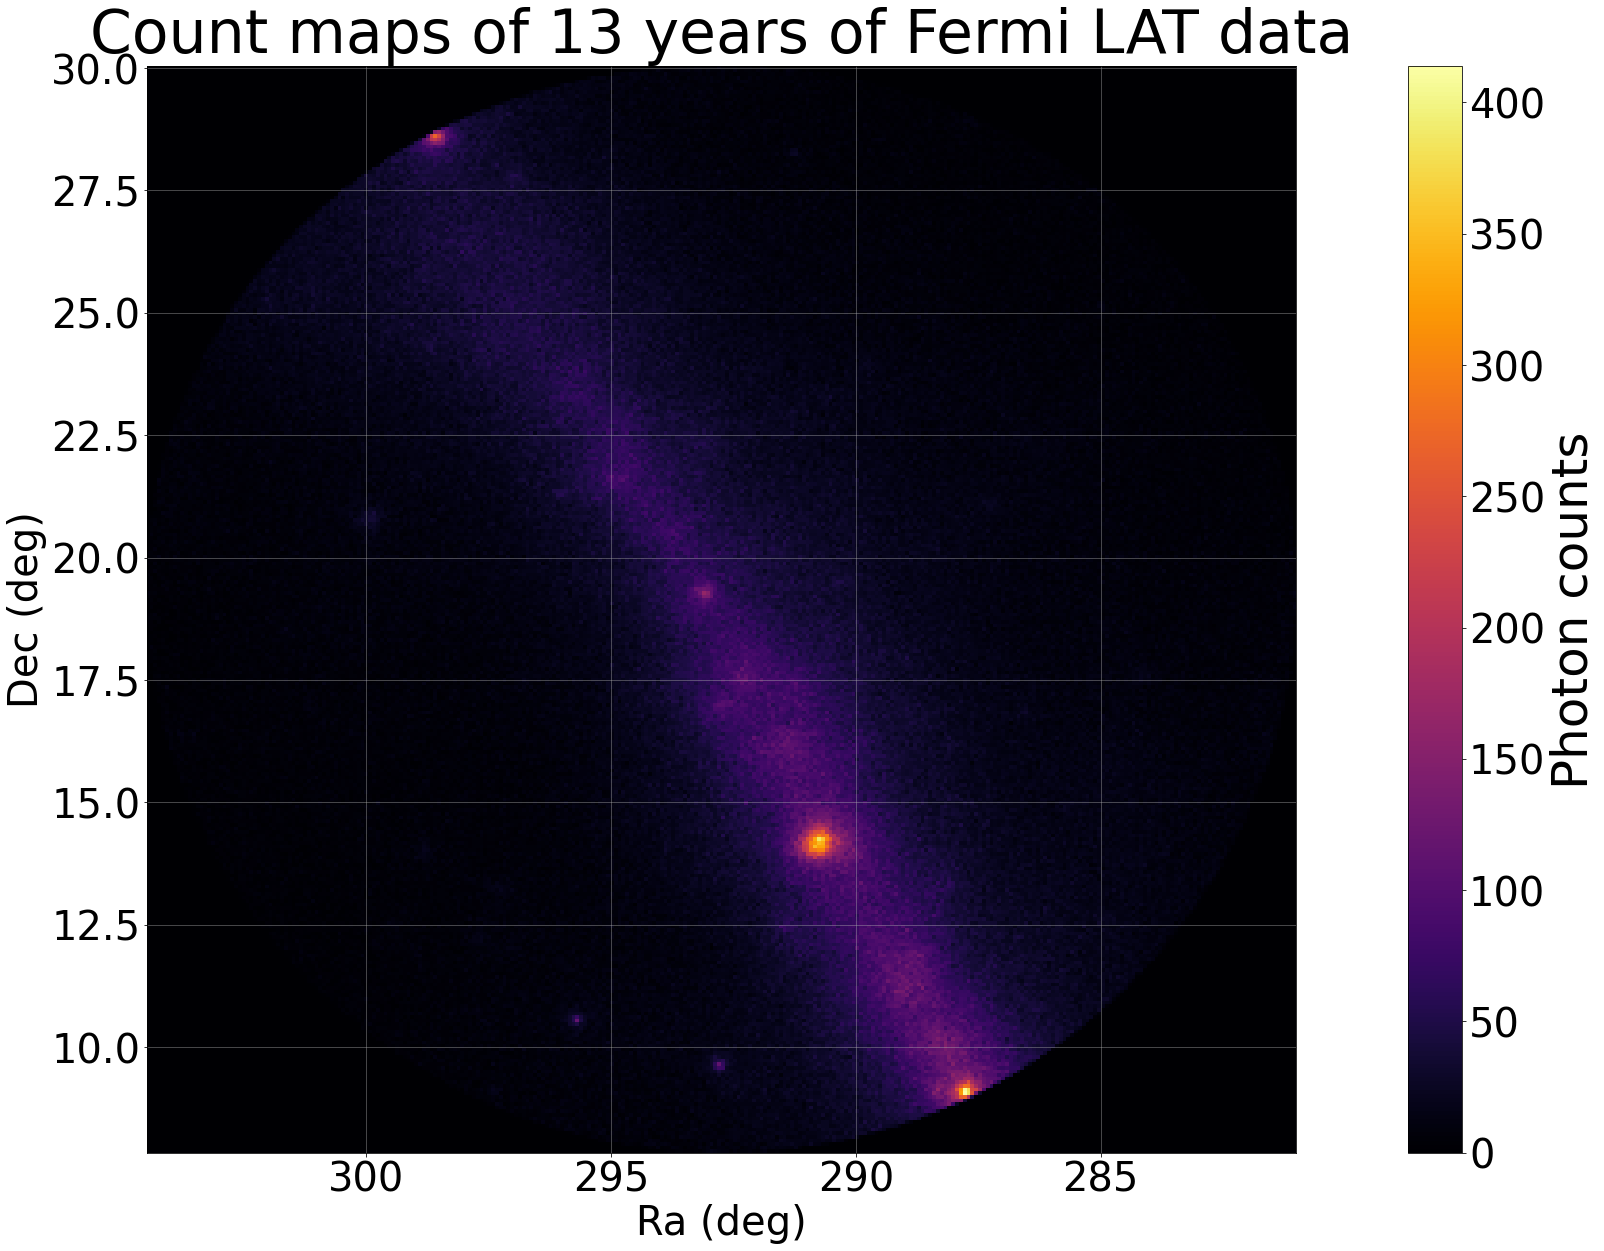

In [13]:
bin = 300
fig, ax = plt.subplots(figsize=(40,20))

count, xedges, yedges = np.histogram2d(x, y, bins = bin) 
count = ax.imshow(count.T, origin='lower',  cmap='inferno',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#ax.scatter((new_t['GLON'] +180)%360 - 180, new_t['GLAT'],edgecolor = 'white' , s=700,facecolor='none')
#for i, txt in enumerate(new_t['Source_Name']):           
#    ax.annotate(txt, (new_t['GLON'][i]+0.35, new_t['GLAT'][i]+0.05),fontsize=30,color='white')

ax.set_xlabel("Ra (deg)",fontsize=40)
ax.set_ylabel("Dec (deg)",fontsize=40)
ax.set_xlim(304.47318, 281.0085)
#ax.set_ylim(0.3-1.5, 0.3+1.5)
ax.grid(alpha=0.5)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
#cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))
cbar = fig.colorbar(count,ax=ax)
cbar.set_label("Photon counts",fontsize=50) 
cbar.ax.tick_params(labelsize=40) 

ax.set_title('Count maps of 13 years of Fermi LAT data',fontsize = 60)


Text(0.5, 1.0, 'Filtered data (J1928+178)')

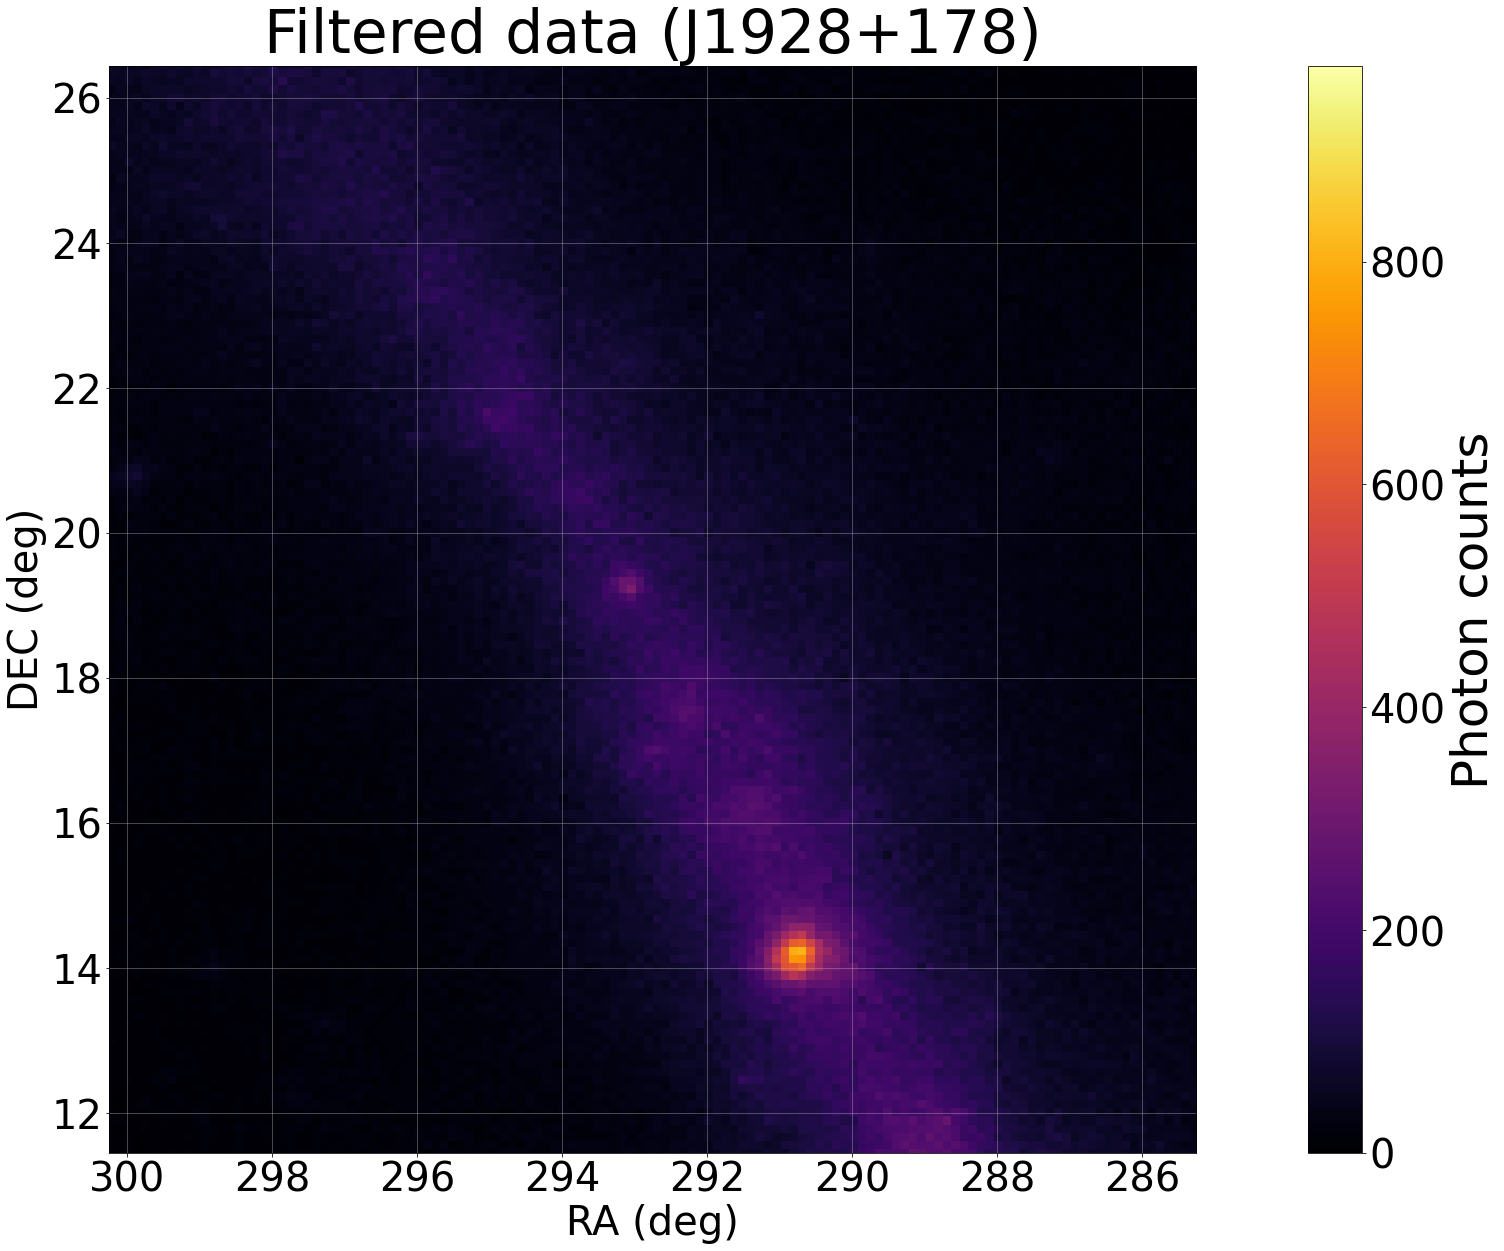

In [14]:
bin = 200
fig, ax = plt.subplots(figsize=(40,20))

count, xedges, yedges = np.histogram2d(x, y, bins = bin) 
count = ax.imshow(count.T, origin='lower',  cmap='inferno',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
#ax.scatter((new_t['GLON'] +180)%360 - 180, new_t['GLAT'],edgecolor = 'white' , s=700,facecolor='none')
#for i, txt in enumerate(new_t['Source_Name']):           
#    ax.annotate(txt, (new_t['GLON'][i]+0.35, new_t['GLAT'][i]+0.05),fontsize=30,color='white')

ax.set_xlabel("RA (deg)",fontsize=40)
ax.set_ylabel("DEC (deg)",fontsize=40)
ax.set_xlim(292.747+7.5, 292.747-7.5)
ax.set_ylim(18.944-7.5, 18.944+7.5)
ax.grid(alpha=0.5)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
#cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))
cbar = fig.colorbar(count,ax=ax)
cbar.set_label("Photon counts",fontsize=50) 
cbar.ax.tick_params(labelsize=40) 

ax.set_title('Filtered data (J1928+178)',fontsize = 60)


In [15]:
#catalog = fits.open('gll_psc_v22.fit')
c = Table(catalog[1].data)

In [16]:
catalog = fits.open("gll_psc_v22.fit")
t = Table(catalog[1].data)
new_glon = np.logical_and(t['RAJ2000'] >=292.747-2.5, t['RAJ2000']<=292.747+2.5)
new_tg = t[new_glon]
new_glat = np.logical_and(new_tg['DEJ2000'] >= 18.944-2.5, new_tg['DEJ2000'] <=18.944+2.5)
sources = new_tg[new_glat]


In [17]:
 gta.print_model()

2022-06-10 11:00:31 INFO    GTAnalysis.print_model(): 
sourcename            offset    norm  eflux     index        ts       npred free
--------------------------------------------------------------------------------
4FGL J1932.3+1916      0.449   2.791  3.99e-05   3.72       nan     30071.8     
4FGL J1929.8+1832      0.482   1.614  1.03e-05   2.42       nan      8548.1     
4FGL J1934.3+1859      0.794   2.658  1.32e-05   4.26       nan     12505.2     
4FGL J1928.4+1801c     1.104   0.954  1.01e-05   2.46       nan      8660.5     
4FGL J1936.6+1921      1.399   0.324  2.48e-06   2.74       nan       975.9     
4FGL J1929.0+1729      1.527   1.526  1.43e-05   3.17       nan     10051.3     
4FGL J1935.2+2029      1.846   1.062  2.33e-05   3.82       nan     22687.6     
4FGL J1925.2+1729      1.991   2.976  6.32e-06   4.69       nan      3730.9     
4FGL J1931.1+1656      2.000   2.820  1.69e-05   3.15       nan     12572.4     
4FGL J1925.1+1707      2.289   0.510  8.78e-06   2.47 

In [18]:
print(gta.roi['4FGL J1921.1+1930'])

Name           : 4FGL J1921.1+1930
Associations   : ['4FGL J1921.1+1930']
RA/DEC         :    290.293/    19.512
GLON/GLAT      :     53.615/     2.509
TS             : nan
Npred          : 5695.57
Flux           : 2.154e-08 +/-      nan
EnergyFlux     : 6.183e-06 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  2.998e-13 +/-        nan
b'Index'       :     -2.527 +/-        nan
b'Scale'       :       1595 +/-        nan


In [19]:
print(gta.roi['4FGL J1925.1+1707'])

Name           : 4FGL J1925.1+1707
Associations   : ['4FGL J1925.1+1707', 'MG2 J192501+1727']
RA/DEC         :    291.289/    17.122
GLON/GLAT      :     51.954/     0.548
TS             : nan
Npred          : 7504.01
Flux           :  2.85e-08 +/-      nan
EnergyFlux     : 8.785e-06 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :    5.1e-14 +/-        nan
b'Index'       :      -2.47 +/-        nan
b'Scale'       :       3843 +/-        nan


In [20]:
print(gta.roi['4FGL J1925.2+1729'])

Name           : 4FGL J1925.2+1729
Associations   : ['4FGL J1925.2+1729', 'PSR J1925+1720', '3EG J1928+1733']
RA/DEC         :    291.322/    17.485
GLON/GLAT      :     52.287/     0.692
TS             : nan
Npred          : 3730.88
Flux           : 9.227e-09 +/-      nan
EnergyFlux     : 6.321e-06 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff2
Spectral Parameters
b'Prefactor'   :  2.976e-11 +/-        nan
b'Index1'      :   -0.08822 +/-        nan
b'Scale'       :       1981 +/-        nan
b'Expfactor'   :    0.02449 +/-        nan
b'Index2'      :     0.6667 +/-        nan


In [21]:
print(gta.roi['4FGL J1928.4+1801c'])

Name           : 4FGL J1928.4+1801c
Associations   : ['4FGL J1928.4+1801c', 'MG2 J192830+1759', '3EG J1928+1733']
RA/DEC         :    292.112/    18.019
GLON/GLAT      :     53.115/     0.285
TS             : nan
Npred          : 8660.53
Flux           : 3.235e-08 +/-      nan
EnergyFlux     : 1.011e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  9.542e-14 +/-        nan
b'Index'       :      -2.46 +/-        nan
b'Scale'       :       3175 +/-        nan


In [22]:
print(gta.roi['4FGL J1929.0+1729'])

Name           : 4FGL J1929.0+1729
Associations   : ['4FGL J1929.0+1729', '3EG J1928+1733']
RA/DEC         :    292.256/    17.490
GLON/GLAT      :     52.717/    -0.088
TS             : nan
Npred          : 10051.32
Flux           : 2.829e-08 +/-      nan
EnergyFlux     : 1.425e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  1.526e-12 +/-        nan
b'alpha'       :      2.644 +/-        nan
b'beta'        :     0.3992 +/-        nan
b'Eb'          :       1634 +/-        nan


In [23]:
print(gta.roi['4FGL J1929.8+1832'])

Name           : 4FGL J1929.8+1832
Associations   : ['4FGL J1929.8+1832', '1RXS J193012.1+183201']
RA/DEC         :    292.454/    18.550
GLON/GLAT      :     53.737/     0.254
TS             : nan
Npred          : 8548.06
Flux           : 3.131e-08 +/-      nan
EnergyFlux     : 1.034e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  1.614e-13 +/-        nan
b'Index'       :     -2.421 +/-        nan
b'Scale'       :       2635 +/-        nan


In [24]:
print(gta.roi['4FGL J1931.1+1656'])

Name           : 4FGL J1931.1+1656
Associations   : ['4FGL J1931.1+1656']
RA/DEC         :    292.785/    16.944
GLON/GLAT      :     52.480/    -0.794
TS             : nan
Npred          : 12572.36
Flux           : 3.736e-08 +/-      nan
EnergyFlux     :  1.69e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :   2.82e-12 +/-        nan
b'alpha'       :      2.532 +/-        nan
b'beta'        :     0.3525 +/-        nan
b'Eb'          :       1324 +/-        nan


In [25]:
print(gta.roi['4FGL J1932.3+1916'])

Name           : 4FGL J1932.3+1916
Associations   : ['4FGL J1932.3+1916', 'PSR J1932+1916']
RA/DEC         :    293.076/    19.268
GLON/GLAT      :     54.650/     0.084
TS             : nan
Npred          : 30071.84
Flux           :  9.12e-08 +/-      nan
EnergyFlux     : 3.992e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff2
Spectral Parameters
b'Prefactor'   :  2.791e-11 +/-        nan
b'Index1'      :     -1.252 +/-        nan
b'Scale'       :       1538 +/-        nan
b'Expfactor'   :    0.01314 +/-        nan
b'Index2'      :     0.6667 +/-        nan


In [26]:
print(gta.roi['4FGL J1934.3+1859'])

Name           : 4FGL J1934.3+1859
Associations   : ['4FGL J1934.3+1859', 'SNR G054.4-00.3']
RA/DEC         :    293.585/    18.998
GLON/GLAT      :     54.646/    -0.468
TS             : nan
Npred          : 12505.20
Flux           : 3.996e-08 +/-      nan
EnergyFlux     : 1.321e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  2.658e-12 +/-        nan
b'alpha'       :      3.137 +/-        nan
b'beta'        :     0.5334 +/-        nan
b'Eb'          :       1105 +/-        nan


In [27]:
print(gta.roi['4FGL J1935.2+2029'])

Name           : 4FGL J1935.2+2029
Associations   : ['4FGL J1935.2+2029', 'PSR J1935+2025']
RA/DEC         :    293.818/    20.491
GLON/GLAT      :     56.057/     0.065
TS             : nan
Npred          : 22687.59
Flux           : 8.072e-08 +/-      nan
EnergyFlux     : 2.335e-05 +/-      nan
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff2
Spectral Parameters
b'Prefactor'   :  1.062e-11 +/-        nan
b'Index1'      :     -1.903 +/-        nan
b'Scale'       :       1190 +/-        nan
b'Expfactor'   :    0.01018 +/-        nan
b'Index2'      :     0.6667 +/-        nan


In [28]:
print(gta.roi['4FGL J1936.6+1921'])

Name           : 4FGL J1936.6+1921
Associations   : ['4FGL J1936.6+1921']
RA/DEC         :    294.163/    19.354
GLON/GLAT      :     55.222/    -0.772
TS             : nan
Npred          : 975.95
Flux           : 1.956e-09 +/-      nan
EnergyFlux     : 2.482e-06 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  3.245e-13 +/-        nan
b'alpha'       :      2.041 +/-        nan
b'beta'        :     0.6762 +/-        nan
b'Eb'          :       1884 +/-        nan


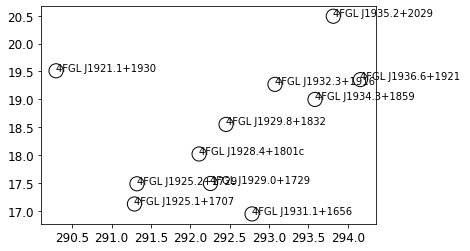

In [29]:
plt.scatter(sources['RAJ2000'], sources['DEJ2000'],edgecolor = 'black' , s=200 , facecolor='none')
for i, txt in enumerate(sources['Source_Name']):           
    plt.annotate(txt, (sources['RAJ2000'][i], sources['DEJ2000'][i]),fontsize=10,color='black')
#plt.ylim(22.0145-2.5,22.0145+2.5)
#plt.xlim(83.633-2.5,83.633+2.5)
plt.show()

Text(0.5, 1.0, 'Filtered data map (J1928+178)')

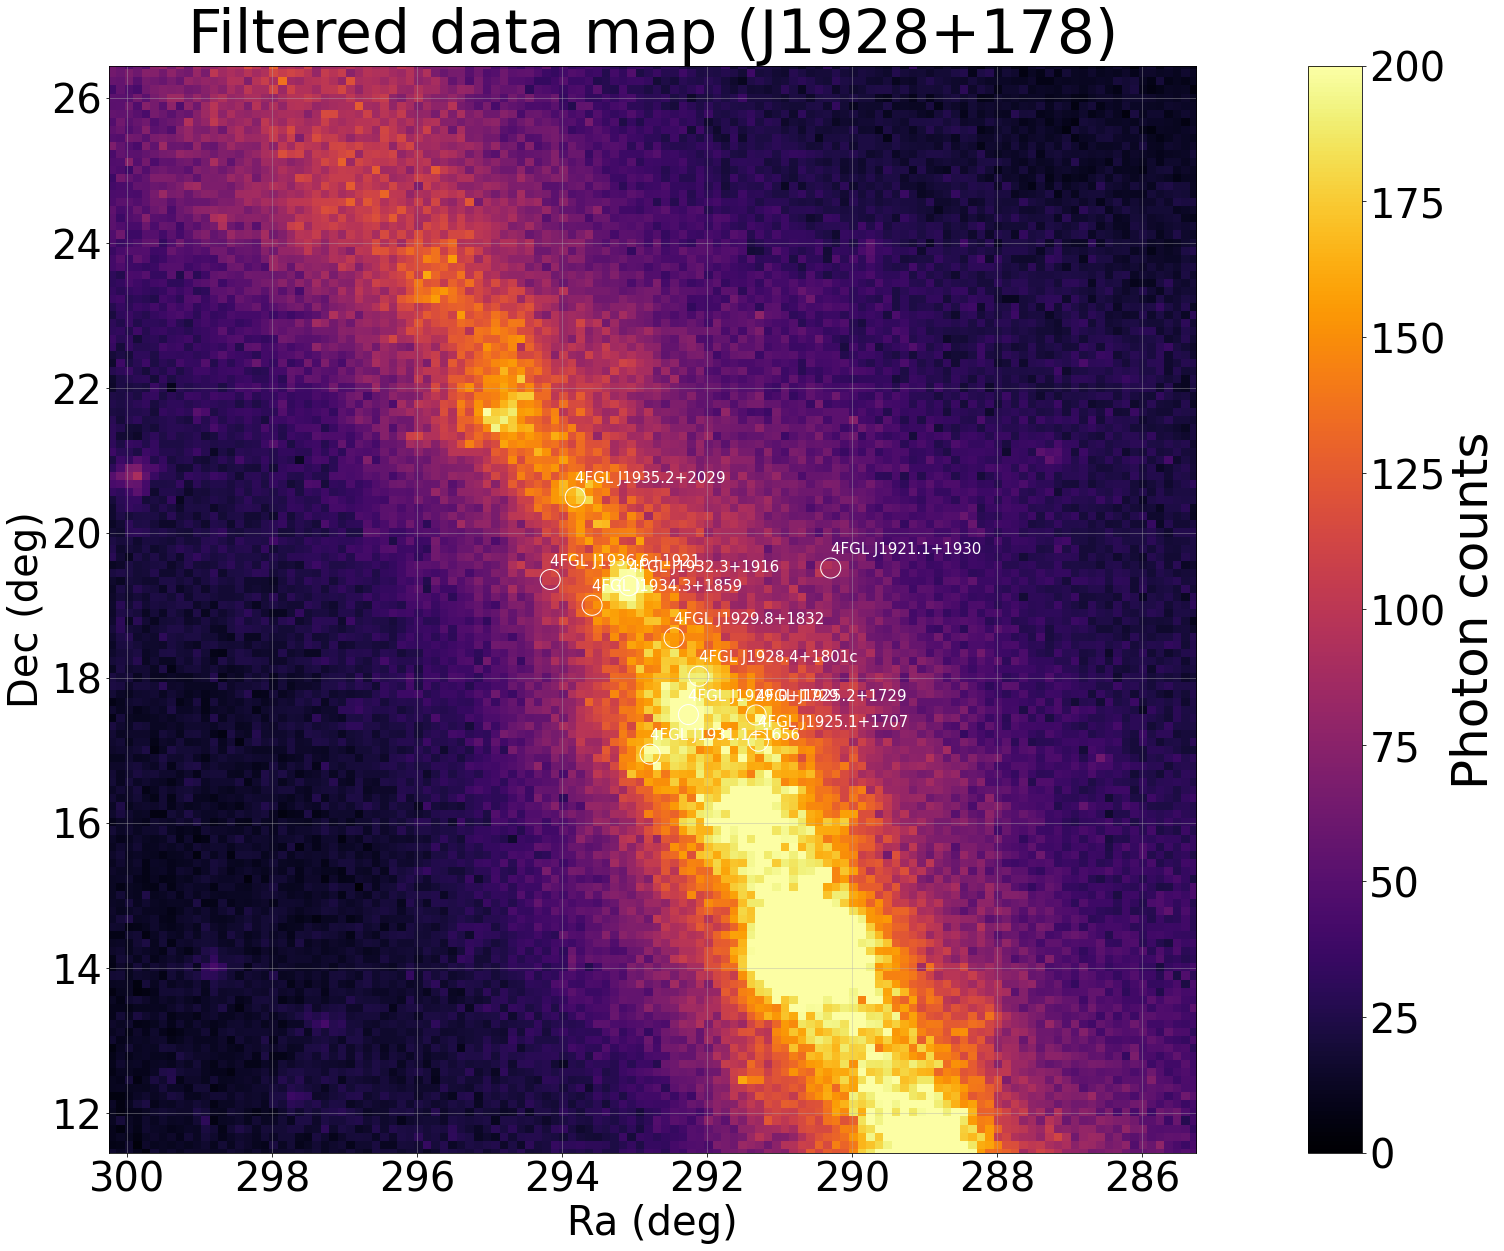

In [30]:
bin = 200
fig, ax = plt.subplots(figsize=(40,20))
count, xedges, yedges = np.histogram2d(x, y, bins = bin) 
count = ax.imshow(count.T, origin='lower',vmax=200,  cmap='inferno',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

for i, txt in enumerate(sources['Source_Name']):           
    ax.annotate(txt, (sources['RAJ2000'][i], sources['DEJ2000'][i]+0.2),fontsize=15,color='white')
ax.scatter(sources['RAJ2000'], sources['DEJ2000'],edgecolor = 'white' , s=400 , facecolor='none')
ax.set_xlabel("Ra (deg)",fontsize=40)
ax.set_ylabel("Dec (deg)",fontsize=40)
ax.set_xlim(292.747+7.5, 292.747-7.5)
ax.set_ylim(18.944-7.5, 18.944+7.5)
ax.grid(alpha=0.5)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
#cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))
cbar = fig.colorbar(count,ax=ax)
cbar.set_label("Photon counts",fontsize=50) 
cbar.ax.tick_params(labelsize=40) 
ax.set_title('Filtered data map (J1928+178)',fontsize = 60)


Text(0.5, 1.0, 'Zoom in filtered data map (J1928+178)')

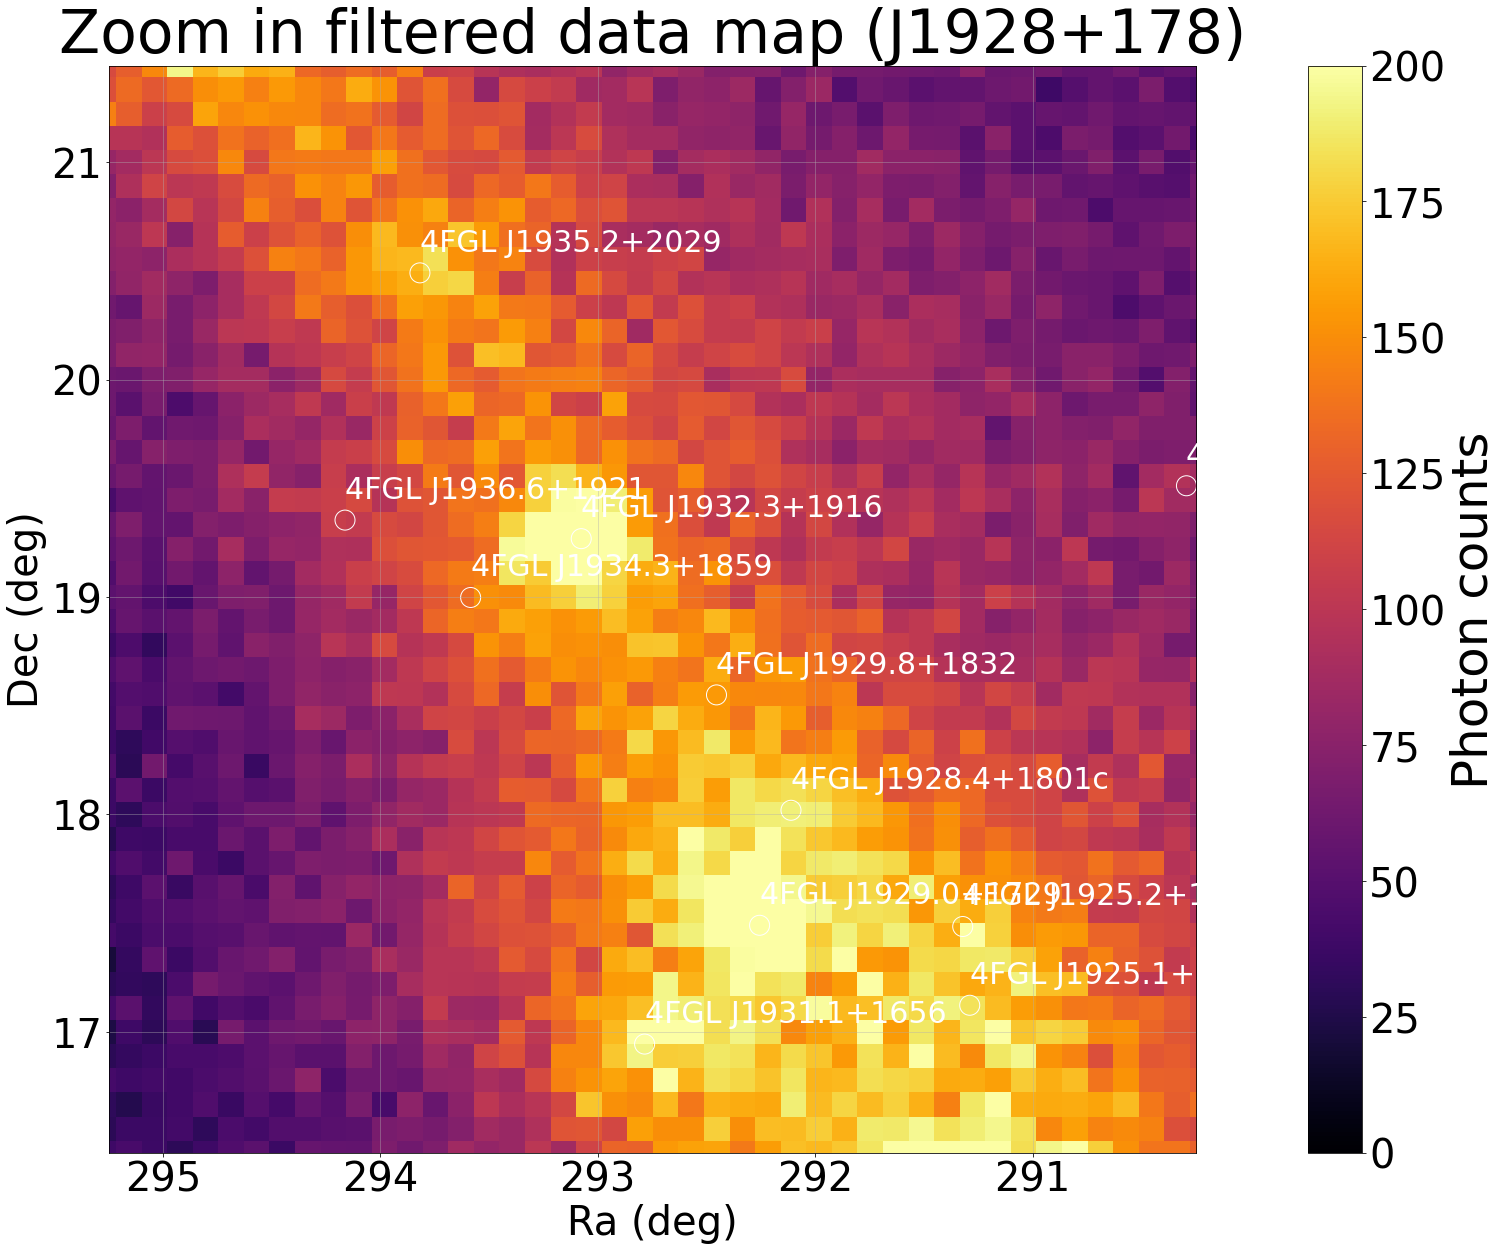

In [31]:
bin = 200
fig, ax = plt.subplots(figsize=(40,20))
count, xedges, yedges = np.histogram2d(x, y, bins = bin) 
count = ax.imshow(count.T, origin='lower',vmax=200,  cmap='inferno',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

for i, txt in enumerate(sources['Source_Name']):           
    ax.annotate(txt, (sources['RAJ2000'][i], sources['DEJ2000'][i]+0.1),fontsize=30,color='white')
ax.scatter(sources['RAJ2000'], sources['DEJ2000'],edgecolor = 'white' , s=400 , facecolor='none')
ax.set_xlabel("Ra (deg)",fontsize=40)
ax.set_ylabel("Dec (deg)",fontsize=40)
ax.set_xlim(292.747+2.5, 292.747-2.5)
ax.set_ylim(18.944-2.5, 18.944+2.5)
ax.grid(alpha=0.5)
ax.tick_params(axis="x", labelsize=40)
ax.tick_params(axis="y", labelsize=40)
#cbar = fig.colorbar(count,ax=ax,ticks=np.arange(0,200,10))
cbar = fig.colorbar(count,ax=ax)
cbar.set_label("Photon counts",fontsize=50) 
cbar.ax.tick_params(labelsize=40) 
ax.set_title('Zoom in filtered data map (J1928+178)',fontsize = 60)


Next, we look at the sky map of the exposure

... and the energy dependence of the exposure for the central pixel

We can now inspect the state of the ROI before the fit

In [32]:
gta.print_roi()

2022-06-10 11:00:33 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1932.3+1916   PointSource    PLSuperExpCuto    0.449       nan     30071.8
4FGL J1929.8+1832   PointSource    PowerLaw          0.482       nan      8548.1
4FGL J1934.3+1859   PointSource    LogParabola       0.794       nan     12505.2
4FGL J1928.4+1801c  PointSource    PowerLaw          1.104       nan      8660.5
4FGL J1936.6+1921   PointSource    LogParabola       1.399       nan       975.9
4FGL J1929.0+1729   PointSource    LogParabola       1.527       nan     10051.3
4FGL J1935.2+2029   PointSource    PLSuperExpCuto    1.846       nan     22687.6
4FGL J1925.2+1729   PointSource    PLSuperExpCuto    1.991       nan      3730.9
4FGL J1931.1+1656   PointSource    LogParabola       2.000       nan     12572.4
4FGL J1925.1+1707   PointSource    PowerLaw          2.2

Additional details about an individual source can be retrieved by printing the corresponding source object

## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [33]:
gta.print_params()

2022-06-10 11:00:34 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------



In [34]:
gta.delete_source('4FGL J1928.4+1801c')
gta.add_source('3HWC J1928+178PSR',{ 'glon' : 52.93, 'glat' : 0.2,
                            'SpectrumType' : 'PLSuperExpCutoff', 'Index1':1.55,
                            'Index2' : 1.0,'Scale' : 1000,'Prefactor':1e-9,'Cutoff' : 1.93e+03 ,'SpatialModel' : 'PointSource' })
gta.add_source('3HWC J1928+178i',{ 'glon' : 52.93, 'glat' : 0.2,
                'SpectrumType' : 'LogParabola', 'alpha' : 1.5,
                'beta' : 0.1, 'norm' : 0.466e-12,'Eb' : 1e+04,
                'SpatialModel': 'RadialGaussian', 'SpatialWidth': 1 })
gta.add_source('3HWC J1928+178s',{ 'glon' : 52.93, 'glat' : 0.2,
                'SpectrumType' : 'PowerLaw', 'Index' : 1.5,
                'Scale' : 1000, 'Prefactor' : 1.0e-11,
                'SpatialModel': 'RadialGaussian', 'SpatialWidth': 1 })

gta.free_sources(free=False) # make sure everything is fixed first
gta.optimize()

2022-06-10 11:00:34 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1928.4+1801c
2022-06-10 11:00:34 INFO    GTAnalysis.add_source(): Adding source 3HWC J1928+178PSR
2022-06-10 11:00:39 INFO    GTAnalysis.add_source(): Adding source 3HWC J1928+178i
2022-06-10 11:01:04 INFO    GTAnalysis.add_source(): Adding source 3HWC J1928+178s
2022-06-10 11:01:28 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178PSR     : ['Prefactor']
2022-06-10 11:01:28 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178i       : ['norm']
2022-06-10 11:01:28 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178s       : ['Prefactor']
2022-06-10 11:01:29 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['galdiff', '3HWC J1928+178PSR', 'isodiff', '4FGL J1923.2+1408e', '4FGL J1932.3+1916']


/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Fitting shape galdiff TS: 2008194.921
Fitting shape 4FGL J1923.2+1408e TS:  30653.411
Fitting shape isodiff TS:   5998.761
Fitting shape 4FGL J1932.3+1916 TS:   2934.586
Fitting shape 4FGL J1931.1+1656 TS:   1504.080
Fitting shape 4FGL J1959.5+2048 TS:   1125.363
Fitting shape 4FGL J1919.4+1313 TS:   1022.273
Fitting shape 4FGL J1922.7+1428 TS:    986.691
Fitting shape 4FGL J1915.3+1149 TS:    969.420
Fitting shape 4FGL J1929.0+1729 TS:    878.172
Fitting shape 4FGL J1934.3+1859 TS:    804.977
Fitting shape 4FGL J1920.9+1408 TS:    764.289
Fitting shape 4FGL J1935.2+2029 TS:    582.669
Fitting shape 4FGL J1925.4+1616 TS:    562.290
Fitting shape 4FGL J1912.5+1320 TS:    522.869
Fitting shape 4FGL J1926.4+1602 TS:    460.601
Fitting shape 4FGL J1955.2+1358 TS:    287.509
Fitting shape 4FGL J1918.1+1215 TS:    266.048
Fitting shape 4FGL J1949.0+1314 TS:    262.450
Fitting shape 4FGL J1944.0+2117 TS:    252.566
Fitting shape 4FGL J1925.7+1227 TS:    230.747
Fitting shape 4FGL J1925.2+1729

2022-06-10 11:10:13 INFO    GTAnalysis.optimize(): Finished
2022-06-10 11:10:13 INFO    GTAnalysis.optimize(): LogLike: 7186739.345134 Delta-LogLike: 585158.566237
2022-06-10 11:10:13 INFO    GTAnalysis.optimize(): Execution time: 524.54 s


{'loglike0': 6601580.778896398,
 'loglike1': 7186739.345133718,
 'dloglike': 585158.5662373202,
 'config': {'npred_threshold': 1.0,
  'npred_frac': 0.95,
  'shape_ts_threshold': 25.0,
  'max_free_sources': 5,
  'skip': [],
  'optimizer': {'optimizer': 'MINUIT',
   'tol': 0.001,
   'max_iter': 100,
   'init_lambda': 0.0001,
   'retries': 3,
   'min_fit_quality': 2,
   'verbosity': 0}}}

In [35]:
print(gta.roi['3HWC J1928+178PSR'])

Name           : 3HWC J1928+178PSR
Associations   : ['3HWC J1928+178PSR']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : -0.76
Npred          : 14.31
Flux           : 4.365e-11 +/- 3.25e-14
EnergyFlux     :  1.87e-08 +/- 1.39e-11
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff
Spectral Parameters
b'Prefactor'   :      1e-14 +/-  7.447e-18
b'Index1'      :      -1.55 +/-        nan
b'Scale'       :       1000 +/-        nan
b'Cutoff'      :       1930 +/-        nan
b'Index2'      :          1 +/-        nan


In [36]:
print(gta.roi['3HWC J1928+178i'])

Name           : 3HWC J1928+178i
Associations   : ['3HWC J1928+178i']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : 88.49
Npred          : 6149.29
Flux           : 1.539e-08 +/- 9.07e-10
EnergyFlux     : 1.567e-05 +/- 2.25e-06
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :   2.71e-14 +/-  5.669e-15
b'alpha'       :      2.566 +/-    0.04935
b'beta'        :        0.2 +/-  3.909e-06
b'Eb'          :      1e+04 +/-        nan


In [37]:
print(gta.roi['3HWC J1928+178s'])

Name           : 3HWC J1928+178s
Associations   : ['3HWC J1928+178s']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : -0.06
Npred          : 0.25
Flux           : 6.262e-13 +/- 2.55e-17
EnergyFlux     : 6.262e-09 +/- 2.55e-13
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :      1e-16 +/-  4.074e-21
b'Index'       :       -1.5 +/-        nan
b'Scale'       :       1000 +/-        nan


In [38]:
# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')
gta.free_sources(minmax_ts=[100,None],pars='norm')
# Free normalizations of isotropic and galactic diffuse components
gta.free_source('galdiff',pars='norm')
gta.free_source('isodiff')

2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1932.3+1916     : ['Prefactor']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1929.8+1832     : ['Prefactor']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1934.3+1859     : ['norm']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 3HWC J1928+178PSR     : ['Prefactor']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 3HWC J1928+178i       : ['norm']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 3HWC J1928+178s       : ['Prefactor']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1936.6+1921     : ['norm']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1929.0+1729     : ['norm']
2022-06-10 11:13:56 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J1935.2+2029     :

In [39]:
print(gta.roi['3HWC J1928+178PSR'])

Name           : 3HWC J1928+178PSR
Associations   : ['3HWC J1928+178PSR']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : -0.76
Npred          : 14.31
Flux           : 4.365e-11 +/- 3.25e-14
EnergyFlux     :  1.87e-08 +/- 1.39e-11
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff
Spectral Parameters
b'Prefactor'   :      1e-14 +/-  7.447e-18
b'Index1'      :      -1.55 +/-        nan
b'Scale'       :       1000 +/-        nan
b'Cutoff'      :       1930 +/-        nan
b'Index2'      :          1 +/-        nan


In [40]:
print(gta.roi['3HWC J1928+178i'])

Name           : 3HWC J1928+178i
Associations   : ['3HWC J1928+178i']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : 88.49
Npred          : 6149.29
Flux           : 1.539e-08 +/- 9.07e-10
EnergyFlux     : 1.567e-05 +/- 2.25e-06
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :   2.71e-14 +/-  5.669e-15
b'alpha'       :      2.566 +/-    0.04935
b'beta'        :        0.2 +/-  3.909e-06
b'Eb'          :      1e+04 +/-        nan


In [41]:
print(gta.roi['3HWC J1928+178s'])

Name           : 3HWC J1928+178s
Associations   : ['3HWC J1928+178s']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : -0.06
Npred          : 0.25
Flux           : 6.262e-13 +/- 2.55e-17
EnergyFlux     : 6.262e-09 +/- 2.55e-13
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :      1e-16 +/-  4.074e-21
b'Index'       :       -1.5 +/-        nan
b'Scale'       :       1000 +/-        nan


In [45]:
gta.free_source('3HWC J1928+178PSR')
gta.free_source('3HWC J1928+178i')
gta.free_source('3HWC J1928+178s')
ext1 = gta.extension('3HWC J1928+178i',update=True,make_plots=True)
ext2 = gta.extension('3HWC J1928+178s',update=True,make_plots=True)

2022-06-10 11:21:03 INFO    GTAnalysis.extension(): Running extension fit for 3HWC J1928+178i
2022-06-10 11:22:26 INFO    GTAnalysis._extension(): Fitting extended-source model.
2022-06-10 11:23:14 INFO    GTAnalysis._extension(): Generating TS map.
2022-06-10 11:23:59 INFO    GTAnalysis._extension(): Testing point-source model.
2022-06-10 11:24:28 INFO    GTAnalysis._extension(): Best-fit extension: 0.7881 + 0.0913 - 0.0889
2022-06-10 11:24:28 INFO    GTAnalysis._extension(): TS_ext:        61.954
2022-06-10 11:24:28 INFO    GTAnalysis._extension(): Extension UL: 0.9396
2022-06-10 11:24:28 INFO    GTAnalysis._extension(): LogLike:  7186742.061 DeltaLogLike:       30.825
2022-06-10 11:24:28 INFO    GTAnalysis.extension(): Finished extension fit.
/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': True, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': True, 'write_fits': True, 'write_npy': True, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None}
{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': True, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': True, 'write_fits': True, 'write_npy': True, 'optimize

2022-06-10 11:24:34 WARNING GTAnalysis.extension(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/user/fermi/J1928+178/J1932+1916_0.1GeV_15_bin6/3hwc_j1928+178i_ext.npy
2022-06-10 11:24:34 INFO    GTAnalysis.extension(): Execution time: 210.31 s
2022-06-10 11:24:34 INFO    GTAnalysis.extension(): Running extension fit for 3HWC J1928+178s


{'name': '3HWC J1928+178i', 'file': None, 'config': {'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': True, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': True, 'write_fits': True, 'write_npy': True, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None}, 'width': array([0.        , 0.01      , 0.01258925, 0.01584893, 0.01995262,
       0.02511886, 0.03162278, 0.03981072, 0.05011872, 0.06309573,
       0.07943282, 0.1       , 0.12589254, 0.15848932, 0.19952623,
       0.25118864, 0.31622777, 0.39810717, 0.50118723, 0.63095734,
       0.79432823, 1.        ]), 'dloglike': array([4.72800899e-03, 4.65516225e-02, 7.3

2022-06-10 11:25:49 INFO    GTAnalysis._extension(): Fitting extended-source model.
2022-06-10 11:26:30 INFO    GTAnalysis._extension(): Generating TS map.
2022-06-10 11:26:50 INFO    GTAnalysis._extension(): Testing point-source model.
2022-06-10 11:27:18 INFO    GTAnalysis._extension(): Best-fit extension: 0.4648 + 0.0225 - 0.0411
2022-06-10 11:27:18 INFO    GTAnalysis._extension(): TS_ext:        0.000
2022-06-10 11:27:18 INFO    GTAnalysis._extension(): Extension UL: 0.5019
2022-06-10 11:27:18 INFO    GTAnalysis._extension(): LogLike:  7186742.061 DeltaLogLike:        0.000
2022-06-10 11:27:18 INFO    GTAnalysis.extension(): Finished extension fit.
/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': True, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': True, 'write_fits': True, 'write_npy': True, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None}
{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': True, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': True, 'write_fits': True, 'write_npy': True, 'optimize

2022-06-10 11:27:24 WARNING GTAnalysis.extension(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /home/user/fermi/J1928+178/J1932+1916_0.1GeV_15_bin6/3hwc_j1928+178s_ext.npy
2022-06-10 11:27:24 INFO    GTAnalysis.extension(): Execution time: 169.90 s


{'name': '3HWC J1928+178s', 'file': None, 'config': {'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': True, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': True, 'write_fits': True, 'write_npy': True, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None}, 'width': array([0.        , 0.01      , 0.01258925, 0.01584893, 0.01995262,
       0.02511886, 0.03162278, 0.03981072, 0.05011872, 0.06309573,
       0.07943282, 0.1       , 0.12589254, 0.15848932, 0.19952623,
       0.25118864, 0.31622777, 0.39810717, 0.50118723, 0.63095734,
       0.79432823, 1.        ]), 'dloglike': array([6.34230673e-07, 5.33098355e-05, 8.4

In [46]:
ext1['ext']

0.7881450904040797

In [47]:
ext2['ext']

0.46483723781526637

In [48]:
print(gta.roi['3HWC J1928+178PSR'])

Name           : 3HWC J1928+178PSR
Associations   : ['3HWC J1928+178PSR']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : -0.76
Npred          : 14.31
Flux           : 4.365e-11 +/- 3.25e-14
EnergyFlux     :  1.87e-08 +/- 1.39e-11
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff
Spectral Parameters
b'Prefactor'   :      1e-14 +/-  7.447e-18
b'Index1'      :      -1.55 +/-        nan
b'Scale'       :       1000 +/-        nan
b'Cutoff'      :       1930 +/-        nan
b'Index2'      :          1 +/-        nan


In [49]:
print(gta.roi['3HWC J1928+178i'])

Name           : 3HWC J1928+178i
Associations   : ['3HWC J1928+178i']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : 89.52
Npred          : 5114.47
Flux           : 1.261e-08 +/-  1.9e-09
EnergyFlux     : 1.379e-05 +/- 2.01e-06
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  2.512e-14 +/-  8.831e-15
b'alpha'       :      2.525 +/-     0.1665
b'beta'        :        0.2 +/-  1.978e-05
b'Eb'          :      1e+04 +/-        nan


In [50]:
print(gta.roi['3HWC J1928+178s'])

Name           : 3HWC J1928+178s
Associations   : ['3HWC J1928+178s']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : -0.00
Npred          : 0.47
Flux           : 1.703e-12 +/-  1.4e-10
EnergyFlux     : 6.286e-10 +/- 3.35e-08
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  1.024e-16 +/-  4.114e-15
b'Index'       :     -2.351 +/-      78.39
b'Scale'       :       1000 +/-        nan


In [51]:
gta.print_params()

2022-06-10 11:27:24 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
3HWC J1928+178PSR
   0 Prefactor                1e-05         0     1e-05     1e+03     1e-09    *
   1 Index1                    1.55         0         0         5        -1    *
   2 Scale                        1         0     0.001     1e+03     1e+03     
   3 Cutoff                    1.93         0     0.001     1e+03     1e+03    *
   4 Index2                       1         0         0         2         1     
3HWC J1928+178i
   5 norm                    0.0251         0     1e-05     1e+03     1e-12    *
   6 alpha                     2.53         0        -5         5         1    *
   7 beta                         2         0        -2         2       0.1    *
   8 Eb                           1         0     0.001     1e+03     1e+04     
3HWC J1928+178s
   

In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [52]:
fit_results = gta.fit()

2022-06-10 11:28:01 INFO    GTAnalysis.fit(): Starting fit.
/home/user/miniconda3/envs/fermi/lib/python3.7/site-packages/scipy/interpolate/fitpack2.py:279: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2022-06-10 11:39:21 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   2 Status: 101
2022-06-10 11:39:21 INFO    GTAnalysis.fit(): LogLike:  7186850.835 DeltaLogLike:      108.774 


The dictionary returned by the fit method returns a variety of diagnostic information about the fit including the fit quality, the relative improvement in the likelihood, and the correlations among the fit parameters. For example :

In [53]:
print('Fit Quality: ',fit_results['fit_quality'])
#print(gta.roi['4FGL J0534.5+2201i'])

Fit Quality:  2


Let's have a look at the sources and the best-fit parameters after the fit

In [92]:
print(gta.roi['3HWC J1928+178PSR'])

Name           : 3HWC J1928+178PSR
Associations   : ['3HWC J1928+178PSR']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : 0.00
Npred          : 0.00
Flux           : 3.669e-25 +/- 1.49e-18
EnergyFlux     : 3.716e-23 +/- 1.54e-16
SpatialModel   : PointSource
SpectrumType   : PLSuperExpCutoff
Spectral Parameters
b'Prefactor'   :  1.064e-14 +/-  6.533e-08
b'Index1'      :    -0.8764 +/-     -3.267
b'Scale'       :       1000 +/-        nan
b'Cutoff'      :        3.6 +/-      757.8
b'Index2'      :          1 +/-        nan


In [93]:
print(gta.roi['3HWC J1928+178i'])

Name           : 3HWC J1928+178i
Associations   : ['3HWC J1928+178i']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : 683.23
Npred          : 25094.05
Flux           : 7.604e-08 +/- 3.53e-09
EnergyFlux     : 3.537e-05 +/- 1.41e-06
SpatialModel   : RadialGaussian
SpectrumType   : LogParabola
Spectral Parameters
b'norm'        :  2.175e-14 +/-  7.269e-16
b'alpha'       :      3.112 +/-   0.009069
b'beta'        :        0.2 +/-  2.158e-06
b'Eb'          :      1e+04 +/-        nan


In [94]:
print(gta.roi['3HWC J1928+178s'])

Name           : 3HWC J1928+178s
Associations   : ['3HWC J1928+178s']
RA/DEC         :    292.097/    17.816
GLON/GLAT      :     52.930/     0.200
TS             : 1.38
Npred          : 53.38
Flux           : 1.206e-10 +/-  5.8e-11
EnergyFlux     : 2.824e-06 +/- 1.56e-06
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :   1.96e-14 +/-  9.426e-15
b'Index'       :      -1.34 +/-   -0.05064
b'Scale'       :       1000 +/-        nan


In [54]:
gta.print_roi()

2022-06-10 11:39:21 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1932.3+1916   PointSource    PLSuperExpCuto    0.449   3543.84     29508.8
4FGL J1929.8+1832   PointSource    PowerLaw          0.482     15.39      2479.5
4FGL J1934.3+1859   PointSource    LogParabola       0.794    512.98     14960.2
3HWC J1928+178PSR   PointSource    PLSuperExpCuto    1.286      0.00         0.0
3HWC J1928+178i     RadialGaussian LogParabola       1.286    683.23     25094.1
3HWC J1928+178s     RadialGaussian PowerLaw          1.286      1.38        53.4
4FGL J1936.6+1921   PointSource    LogParabola       1.399     63.03      2146.9
4FGL J1929.0+1729   PointSource    LogParabola       1.527    260.15      9355.0
4FGL J1935.2+2029   PointSource    PLSuperExpCuto    1.846    464.24     14300.6
4FGL J1925.2+1729   PointSource    PLSuperExpCuto    1.9

In [55]:
gta.print_params()

2022-06-10 11:39:21 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
3HWC J1928+178PSR
   0 Prefactor             1.06e-05      65.3     1e-05     1e+03     1e-09    *
   1 Index1                   0.876      3.27         0         5        -1    *
   2 Scale                        1         0     0.001     1e+03     1e+03     
   3 Cutoff                  0.0036     0.758     0.001     1e+03     1e+03    *
   4 Index2                       1         0         0         2         1     
3HWC J1928+178i
   5 norm                    0.0217  0.000727     1e-05     1e+03     1e-12    *
   6 alpha                     3.11   0.00907        -5         5         1    *
   7 beta                         2  2.16e-05        -2         2       0.1    *
   8 Eb                           1         0     0.001     1e+03     1e+04     
3HWC J1928+178s
   

You can then save the state of the roi to an output file for reference later.

2022-06-10 11:39:21 INFO    GTBinnedAnalysis.write_xml(): Writing /home/user/fermi/J1928+178/J1932+1916_0.1GeV_15_bin6/J1928+178_0.1GeV_3_component_00.xml...
2022-06-10 11:39:21 INFO    GTAnalysis.write_fits(): Writing /home/user/fermi/J1928+178/J1932+1916_0.1GeV_15_bin6/J1928+178_0.1GeV_3_component.fits...
2022-06-10 11:39:36 INFO    GTAnalysis.write_roi(): Writing /home/user/fermi/J1928+178/J1932+1916_0.1GeV_15_bin6/J1928+178_0.1GeV_3_component.npy...


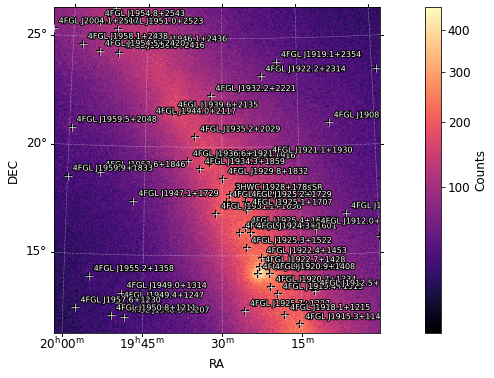

In [56]:
#gta.write_roi('fit0',make_plots=True)
gta.write_roi('J1928+178_0.1GeV_3_component',make_plots=True)

We can also inspect the final model map. The next command will return the model map as a `gammapy.Map` instance (Full documentation for `gammapy`  [here](https://docs.gammapy.org)).

In [ ]:
#model_map = gta.write_model_map("Pulsar_J1932")

In [ ]:
#print(model_map)

In [ ]:
#model_map[0].geom.axes[0]

Plot the model map summed over the energy axis. The plot shows the predicted number of counts for all model components. 

In [ ]:
#model_map[0].sum_over_axes(["energy"]).plot(stretch="sqrt",cmap='plasma', add_cbar=True)
#plt.savefig("J1928+178_15_bin3/model.png")

Plot each energy bin of the model map. This nicely illustrates the broad PSF at low energies. 

In [ ]:
#model_map_bins = model_map[0].plot_grid(stretch="sqrt",cmap='plasma', add_cbar=True)
#plt.savefig("J1928+178_15_bin6/model_bins.png")

### Reading in the results

The results are saved and you can retrieve them from the output numpy file. 

In [57]:
ls J1932+1916_15_bin_3/*npy

J1932+1916_15_bin_3/4fgl_j1925.2+1729_sed.npy
J1932+1916_15_bin_3/4fgl_j1928.4+1801c_sed.npy
J1932+1916_15_bin_3/4fgl_j1929.0+1729_sed.npy
J1932+1916_15_bin_3/4fgl_j1932.3+1916i_ext.npy
J1932+1916_15_bin_3/4fgl_j1932.3+1916i_sed.npy
J1932+1916_15_bin_3/4fgl_j1932.3+1916_sed.npy
J1932+1916_15_bin_3/4fgl_j1935.2+2029_sed.npy
J1932+1916_15_bin_3/Pulsar_J1932.npy
J1932+1916_15_bin_3/Reference.npy
J1932+1916_15_bin_3/Reference_pointsource_powerlaw_2.00_residmap.npy


In [58]:
c = np.load('J1932+1916_0.1GeV_15_bin6/J1928+178_0.1GeV_3_component.npy', allow_pickle=True).flat[0]

The `sources` dictionary has an entry for each source in the model:

In [59]:
sorted(c['sources'].keys())

['3HWC J1928+178PSR',
 '3HWC J1928+178i',
 '3HWC J1928+178s',
 '4FGL J1841.3+2909',
 '4FGL J1842.1+2737',
 '4FGL J1844.4+1547',
 '4FGL J1845.0+1613',
 '4FGL J1846.3+0919',
 '4FGL J1849.4+2745',
 '4FGL J1850.5+2631',
 '4FGL J1851.5+0718',
 '4FGL J1855.2+0756',
 '4FGL J1856.2+0749',
 '4FGL J1856.5+1735',
 '4FGL J1857.2+0941',
 '4FGL J1858.5+0640',
 '4FGL J1859.0+2329',
 '4FGL J1859.8+1545',
 '4FGL J1901.1+0730',
 '4FGL J1902.5+0654',
 '4FGL J1906.1+1651',
 '4FGL J1906.2+0631',
 '4FGL J1906.4+0723',
 '4FGL J1906.9+0712',
 '4FGL J1908.6+0915e',
 '4FGL J1908.7+0812',
 '4FGL J1908.9+2103',
 '4FGL J1910.2+0904',
 '4FGL J1910.8+2856',
 '4FGL J1911.0+0905',
 '4FGL J1911.7+1014',
 '4FGL J1912.0+1612',
 '4FGL J1912.5+1320',
 '4FGL J1912.7+0957',
 '4FGL J1913.3+0905',
 '4FGL J1913.3+1019',
 '4FGL J1914.5+1107',
 '4FGL J1914.7+1012',
 '4FGL J1915.3+1149',
 '4FGL J1916.3+1108',
 '4FGL J1918.1+1215',
 '4FGL J1919.1+2354',
 '4FGL J1919.4+1313',
 '4FGL J1920.7+1334',
 '4FGL J1920.9+1408',
 '4FGL J1921.

Let's take a look at the flux, spectral parameters, and TS of one of the sources.

In [60]:
gta.print_roi()

2022-06-10 11:42:45 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1932.3+1916   PointSource    PLSuperExpCuto    0.449   3543.84     29508.8
4FGL J1929.8+1832   PointSource    PowerLaw          0.482     15.39      2479.5
4FGL J1934.3+1859   PointSource    LogParabola       0.794    512.98     14960.2
3HWC J1928+178PSR   PointSource    PLSuperExpCuto    1.286      0.00         0.0
3HWC J1928+178i     RadialGaussian LogParabola       1.286    683.23     25094.1
3HWC J1928+178s     RadialGaussian PowerLaw          1.286      1.38        53.4
4FGL J1936.6+1921   PointSource    LogParabola       1.399     63.03      2146.9
4FGL J1929.0+1729   PointSource    LogParabola       1.527    260.15      9355.0
4FGL J1935.2+2029   PointSource    PLSuperExpCuto    1.846    464.24     14300.6
4FGL J1925.2+1729   PointSource    PLSuperExpCuto    1.9

You can also plot the spectral energy distribution (SED) for this source :

# 3HWC J1928+178PSR

In [61]:
loge_bins=gta.log_energies[::2]

2022-06-10 11:45:44 INFO    GTAnalysis.sed(): Computing SED for 3HWC J1928+178PSR
2022-06-10 11:46:08 INFO    GTAnalysis._make_sed(): Fitting SED
2022-06-10 11:46:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178PSR     : ['Index1', 'Cutoff']
2022-06-10 11:46:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178i       : ['alpha', 'beta']
2022-06-10 11:46:08 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178s       : ['Index']
2022-06-10 11:46:25 INFO    GTAnalysis.sed(): Finished SED
2022-06-10 11:46:32 INFO    GTAnalysis.sed(): Execution time: 48.10 s


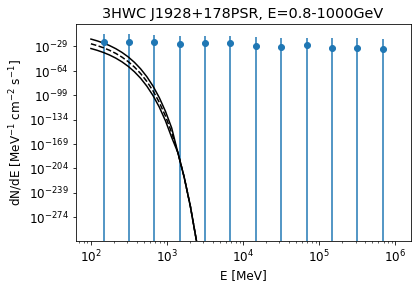

In [62]:
E178PSR = np.array(c['sources']['3HWC J1928+178PSR']['model_flux']['energies'])
dnde178PSR = np.array(c['sources']['3HWC J1928+178PSR']['model_flux']['dnde'])
dnde_hi178PSR = np.array(c['sources']['3HWC J1928+178PSR']['model_flux']['dnde_hi'])
dnde_lo178PSR = np.array(c['sources']['3HWC J1928+178PSR']['model_flux']['dnde_lo'])
sed178PSR = gta.sed('3HWC J1928+178PSR',loge_bins=loge_bins)
plt.errorbar(sed178PSR['e_ctr'],
             sed178PSR['dnde'], 
             yerr=sed178PSR['dnde_err'], fmt ='o')
plt.loglog(E178PSR, dnde178PSR, 'k--')
plt.loglog(E178PSR, dnde_hi178PSR, 'k')
plt.loglog(E178PSR, dnde_lo178PSR, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.title('3HWC J1928+178PSR, E=0.1-1000GeV')
plt.show()
#plt.savefig("crab_2019/spectrum.png")

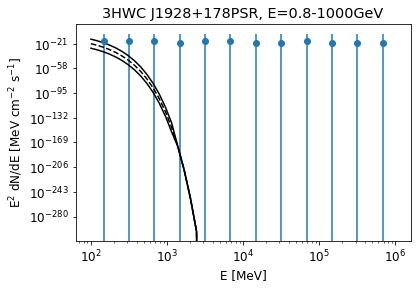

In [63]:
plt.loglog(E178PSR, (E178PSR**2)*dnde178PSR, 'k--')
plt.loglog(E178PSR, (E178PSR**2)*dnde_hi178PSR, 'k')
plt.loglog(E178PSR, (E178PSR**2)*dnde_lo178PSR, 'k')
plt.errorbar(sed178PSR['e_ctr'],
             sed178PSR['e2dnde'], 
             yerr=sed178PSR['e2dnde_err'], fmt ='o')
#plt.errorbar(np.array(sed['e_ctr'][-3:]),
#         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
#             fmt='o', uplims=True)
plt.title('3HWC J1928+178PSR, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

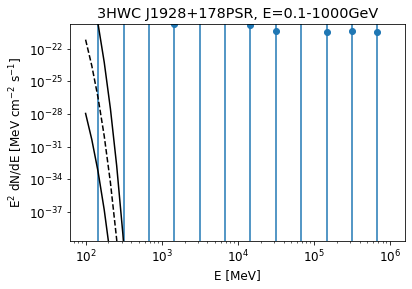

In [86]:
plt.loglog(E178PSR, (E178PSR**2)*dnde178PSR, 'k--')
plt.loglog(E178PSR, (E178PSR**2)*dnde_hi178PSR, 'k')
plt.loglog(E178PSR, (E178PSR**2)*dnde_lo178PSR, 'k')
plt.errorbar(sed178PSR['e_ctr'],
             sed178PSR['e2dnde'], 
             yerr=sed178PSR['e2dnde_err'], fmt ='o')
#plt.errorbar(np.array(sed['e_ctr'][-3:]),
#         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
#             fmt='o', uplims=True)
plt.title('3HWC J1928+178PSR, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.ylim(2E-40,2E-20)
plt.show()

# 3HWC J1928+178i

2022-06-10 11:48:24 INFO    GTAnalysis.sed(): Computing SED for 3HWC J1928+178i
2022-06-10 11:52:53 INFO    GTAnalysis._make_sed(): Fitting SED
2022-06-10 11:52:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178PSR     : ['Index1', 'Cutoff']
2022-06-10 11:52:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178i       : ['alpha', 'beta']
2022-06-10 11:52:53 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178s       : ['Index']
2022-06-10 11:53:12 INFO    GTAnalysis.sed(): Finished SED
2022-06-10 11:53:21 INFO    GTAnalysis.sed(): Execution time: 296.94 s


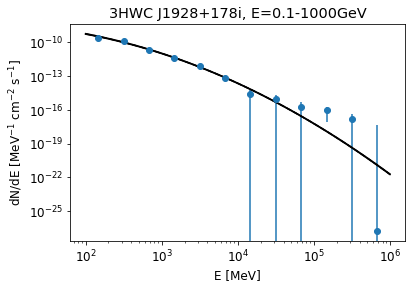

In [65]:
E178i = np.array(c['sources']['3HWC J1928+178i']['model_flux']['energies'])
dnde178i = np.array(c['sources']['3HWC J1928+178i']['model_flux']['dnde'])
dnde_hi178i = np.array(c['sources']['3HWC J1928+178i']['model_flux']['dnde_hi'])
dnde_lo178i = np.array(c['sources']['3HWC J1928+178i']['model_flux']['dnde_lo'])
sed178i = gta.sed('3HWC J1928+178i',loge_bins=loge_bins)
plt.errorbar(sed178i['e_ctr'],
             sed178i['dnde'], 
             yerr=sed178i['dnde_err'], fmt ='o')
plt.loglog(E178i, dnde178i, 'k--')
plt.loglog(E178i, dnde_hi178i, 'k')
plt.loglog(E178i, dnde_lo178i, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.title('3HWC J1928+178i, E=0.1-1000GeV')
plt.show()
#plt.savefig("crab_2019/spectrum.png")

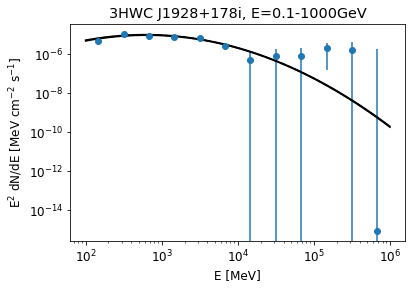

In [66]:
plt.loglog(E178i, (E178i**2)*dnde178i, 'k--')
plt.loglog(E178i, (E178i**2)*dnde_hi178i, 'k')
plt.loglog(E178i, (E178i**2)*dnde_lo178i, 'k')
plt.errorbar(sed178i['e_ctr'],
             sed178i['e2dnde'], 
             yerr=sed178i['e2dnde_err'], fmt ='o')
#plt.errorbar(np.array(sed['e_ctr'][-3:]),
#         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
#             fmt='o', uplims=True)
plt.title('3HWC J1928+178i, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

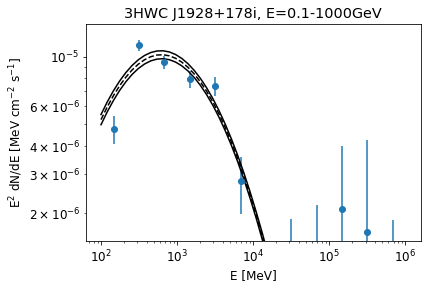

In [91]:
plt.loglog(E178i, (E178i**2)*dnde178i, 'k--')
plt.loglog(E178i, (E178i**2)*dnde_hi178i, 'k')
plt.loglog(E178i, (E178i**2)*dnde_lo178i, 'k')
plt.errorbar(sed178i['e_ctr'],
             sed178i['e2dnde'], 
             yerr=sed178i['e2dnde_err'], fmt ='o')
#plt.errorbar(np.array(sed['e_ctr'][-3:]),
#         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
#             fmt='o', uplims=True)
plt.title('3HWC J1928+178i, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.ylim(1.5E-6,1.4E-5)
plt.show()



# 3HWC J1928+178s

2022-06-10 11:53:24 INFO    GTAnalysis.sed(): Computing SED for 3HWC J1928+178s
2022-06-10 11:57:41 INFO    GTAnalysis._make_sed(): Fitting SED
2022-06-10 11:57:41 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178PSR     : ['Index1', 'Cutoff']
2022-06-10 11:57:41 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178i       : ['alpha', 'beta']
2022-06-10 11:57:41 INFO    GTAnalysis.free_source(): Fixing parameters for 3HWC J1928+178s       : ['Index']
2022-06-10 11:57:58 INFO    GTAnalysis.sed(): Finished SED
2022-06-10 11:58:06 INFO    GTAnalysis.sed(): Execution time: 282.13 s


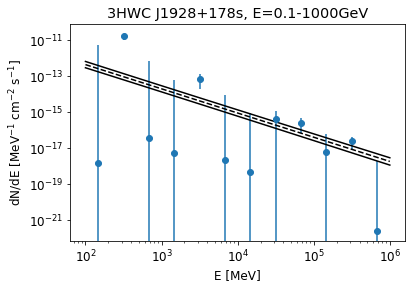

In [68]:
E178s = np.array(c['sources']['3HWC J1928+178s']['model_flux']['energies'])
dnde178s = np.array(c['sources']['3HWC J1928+178s']['model_flux']['dnde'])
dnde_hi178s = np.array(c['sources']['3HWC J1928+178s']['model_flux']['dnde_hi'])
dnde_lo178s = np.array(c['sources']['3HWC J1928+178s']['model_flux']['dnde_lo'])
sed178s = gta.sed('3HWC J1928+178s',loge_bins=loge_bins)
plt.errorbar(sed178s['e_ctr'],
             sed178s['dnde'], 
             yerr=sed178s['dnde_err'], fmt ='o')
plt.loglog(E178s, dnde178s, 'k--')
plt.loglog(E178s, dnde_hi178s, 'k')
plt.loglog(E178s, dnde_lo178s, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
plt.title('3HWC J1928+178s, E=0.1-1000GeV')
plt.show()
#plt.savefig("crab_2019/spectrum.png")

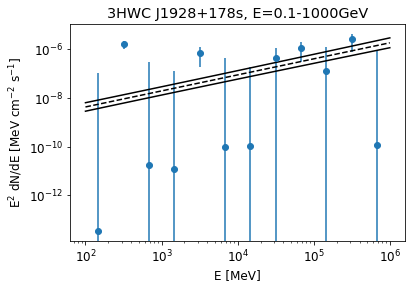

In [69]:
plt.loglog(E178s, (E178s**2)*dnde178s, 'k--')
plt.loglog(E178s, (E178s**2)*dnde_hi178s, 'k')
plt.loglog(E178s, (E178s**2)*dnde_lo178s, 'k')
plt.errorbar(sed178s['e_ctr'],
             sed178s['e2dnde'], 
             yerr=sed178s['e2dnde_err'], fmt ='o')
#plt.errorbar(np.array(sed['e_ctr'][-3:]),
#         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
#             fmt='o', uplims=True)
plt.title('3HWC J1928+178s, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

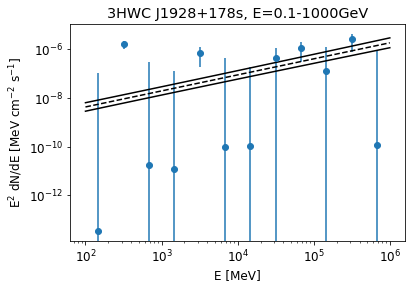

In [70]:
plt.loglog(E178s, (E178s**2)*dnde178s, 'k--')
plt.loglog(E178s, (E178s**2)*dnde_hi178s, 'k')
plt.loglog(E178s, (E178s**2)*dnde_lo178s, 'k')
plt.errorbar(sed178s['e_ctr'],
             sed178s['e2dnde'], 
             yerr=sed178s['e2dnde_err'], fmt ='o')
#plt.errorbar(np.array(sed['e_ctr'][-3:]),
#         sed['e2dnde_ul95'][-3:], yerr=0.2*sed['e2dnde_ul95'][-3:], 
#             fmt='o', uplims=True)
plt.title('3HWC J1928+178s, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

# 3HWC J1928+178

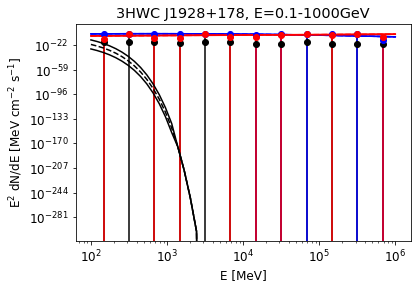

In [71]:
plt.loglog(E178PSR, (E178PSR**2)*dnde178PSR, 'k--')
plt.loglog(E178PSR, (E178PSR**2)*dnde_hi178PSR, 'k')
plt.loglog(E178PSR, (E178PSR**2)*dnde_lo178PSR, 'k')
plt.errorbar(sed178PSR['e_ctr'],
             sed178PSR['e2dnde'], 
             yerr=sed178PSR['e2dnde_err'], fmt ='ko')

plt.loglog(E178i, (E178i**2)*dnde178i, 'b--')
plt.loglog(E178i, (E178i**2)*dnde_hi178i, 'b')
plt.loglog(E178i, (E178i**2)*dnde_lo178i, 'b')
plt.errorbar(sed178i['e_ctr'],
             sed178i['e2dnde'], 
             yerr=sed178i['e2dnde_err'], fmt ='bo')

plt.loglog(E178s, (E178s**2)*dnde178s, 'r--')
plt.loglog(E178s, (E178s**2)*dnde_hi178s, 'r')
plt.loglog(E178s, (E178s**2)*dnde_lo178s, 'r')
plt.errorbar(sed178s['e_ctr'],
             sed178s['e2dnde'], 
             yerr=sed178s['e2dnde_err'], fmt ='ro')

plt.title('3HWC J1928+178, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')

plt.show()

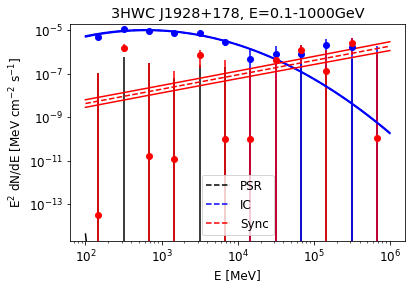

In [77]:
plt.loglog(E178PSR, (E178PSR**2)*dnde178PSR, 'k--',label='PSR')
plt.loglog(E178PSR, (E178PSR**2)*dnde_hi178PSR, 'k')
plt.loglog(E178PSR, (E178PSR**2)*dnde_lo178PSR, 'k')
plt.errorbar(sed178PSR['e_ctr'],
             sed178PSR['e2dnde'], 
             yerr=sed178PSR['e2dnde_err'], fmt ='ko')

plt.loglog(E178i, (E178i**2)*dnde178i, 'b--',label='IC')
plt.loglog(E178i, (E178i**2)*dnde_hi178i, 'b')
plt.loglog(E178i, (E178i**2)*dnde_lo178i, 'b')
plt.errorbar(sed178i['e_ctr'],
             sed178i['e2dnde'], 
             yerr=sed178i['e2dnde_err'], fmt ='bo')

plt.loglog(E178s, (E178s**2)*dnde178s, 'r--',label='Sync')
plt.loglog(E178s, (E178s**2)*dnde_hi178s, 'r')
plt.loglog(E178s, (E178s**2)*dnde_lo178s, 'r')
plt.errorbar(sed178s['e_ctr'],
             sed178s['e2dnde'], 
             yerr=sed178s['e2dnde_err'], fmt ='ro')
plt.legend()
plt.title('3HWC J1928+178, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.ylim(2e-15,2e-5)
plt.show()

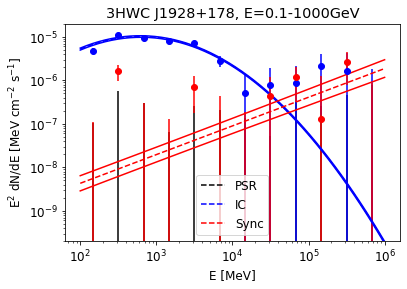

In [82]:
plt.loglog(E178PSR, (E178PSR**2)*dnde178PSR, 'k--',label='PSR')
plt.loglog(E178PSR, (E178PSR**2)*dnde_hi178PSR, 'k')
plt.loglog(E178PSR, (E178PSR**2)*dnde_lo178PSR, 'k')
plt.errorbar(sed178PSR['e_ctr'],
             sed178PSR['e2dnde'], 
             yerr=sed178PSR['e2dnde_err'], fmt ='ko')

plt.loglog(E178i, (E178i**2)*dnde178i, 'b--',label='IC')
plt.loglog(E178i, (E178i**2)*dnde_hi178i, 'b')
plt.loglog(E178i, (E178i**2)*dnde_lo178i, 'b')
plt.errorbar(sed178i['e_ctr'],
             sed178i['e2dnde'], 
             yerr=sed178i['e2dnde_err'], fmt ='bo')

plt.loglog(E178s, (E178s**2)*dnde178s, 'r--',label='Sync')
plt.loglog(E178s, (E178s**2)*dnde_hi178s, 'r')
plt.loglog(E178s, (E178s**2)*dnde_lo178s, 'r')
plt.errorbar(sed178s['e_ctr'],
             sed178s['e2dnde'], 
             yerr=sed178s['e2dnde_err'], fmt ='ro')
plt.legend()
plt.title('3HWC J1928+178, E=0.1-1000GeV')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]')
plt.ylim(2e-10,2e-5)
plt.show()